In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.ensemble import IsolationForest


In [2]:
PATH= os.path.abspath(os.getcwd())
transfer= pd.read_csv(PATH + '/transfer2.csv') 

# transfer
transfer_dataset = transfer

full_transfer = pd.DataFrame()
full_transfer['x1'] = transfer_dataset[" DEPOSIT AMT "]
full_transfer['x2'] = transfer_dataset["BALANCE AMT"]
full_transfer=full_transfer.fillna(0)

In [3]:
# create abnormal data
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse,AddNoise,Convolve
my_augmenter = (
    TimeWarp() *1  # random time warping 5 times in parallel
    + Quantize(n_levels=[15, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
    + Drift(max_drift=(0.1, 0.4)) @ 0.5  # with 80% probability, random drift the signal up to 10% - 50%
    + Reverse() @ 0.1  # with 50% probability, reverse the sequence
    + AddNoise(scale=(0.01, 0.05)) @ 0.5
    )
my_augmenter2 = (
    TimeWarp() *4
    + Quantize(n_levels=[900, 1500,2000 ])
    + Drift(max_drift=(0.1, 0.8)) @ 0.9  # with 80% probability, random drift the signal up to 10% - 50%
    + AddNoise(scale=(0.8, 0.8)) @ 0.7
    )
my_augmenter3 = (
    TimeWarp() *4
    + Quantize(n_levels=[900, 1500,2000 ])
    + Drift(max_drift=(0.1, 0.8)) @ 0.9  # with 80% probability, random drift the signal up to 10% - 50%
    + AddNoise(scale=(0.8, 0.8)) @ 0.5
    )
    

In [4]:
# Data Preprocessing
for i in range(len(full_transfer)):
    if full_transfer['x1'][i] != 0:
        full_transfer['x1'][i]=full_transfer['x1'][i].replace(',','').split()[0].split('.')[0]
for i in range(len(full_transfer)):
    if full_transfer['x2'][i] != 0:
        full_transfer['x2'][i]=full_transfer['x2'][i].replace(',','').split()[0].split('.')[0]
full_transfer['x1']=full_transfer['x1'].astype(int)
full_transfer['x2']=full_transfer['x2'].astype(int)


In [21]:
full_transfer = full_transfer[:10000]
transfer_abnormal_rnd1 = np.random.uniform(low=0, high=169047, size=(len(full_transfer), 1))
transfer_abnormal_rnd2 = np.random.uniform(low=-54379894, high=-54226062, size=(len(full_transfer), 1))
transfer_abnormal_rnd1 = np.array(transfer_abnormal_rnd1)
transfer_abnormal_rnd2 = np.array(transfer_abnormal_rnd2)

transfer_abnormal_rnd = np.concatenate([transfer_abnormal_rnd1,transfer_abnormal_rnd2],axis=1)

transfer_abnormal = pd.DataFrame(transfer_abnormal_rnd,columns=["x1","x2"])

x_times = np.arange(len(full_transfer["x1"]))
x_aug1,y_aug1 = my_augmenter3.augment(x_times,full_transfer["x1"].to_numpy())
x_aug2,y_aug2 = my_augmenter3.augment(x_times,full_transfer["x2"].to_numpy())

transfer_abnormal['x1'] = transfer_abnormal['x1']*0.6 +(y_aug1[3]*0.4)
transfer_abnormal['x2'] = transfer_abnormal['x2']*0.02+(y_aug2[3])


In [7]:
transfer_abnormal_y =pd.DataFrame()
transfer_abnormal_y['y'] =  transfer_abnormal['x1']
transfer_abnormal_y['y']=-1
transfer_abnormal_y2 =pd.DataFrame()
transfer_abnormal_y2['y'] =  transfer_abnormal['x1']
transfer_abnormal_y2['y']=0

In [22]:

rnd_idx1 = int(np.random.uniform(low=0, high=2000, size=(1, 1)))
rnd_idx2 = int(np.random.uniform(low=2000, high=4000, size=(1, 1)))
rnd_idx3 = int(np.random.uniform(low=4700, high=6800, size=(1, 1)))
rnd_idx4 = int(np.random.uniform(low=6800, high=8900, size=(1, 1)))
rnd_idx5 = int(np.random.uniform(low=8900, high=9900, size=(1, 1)))

transfer_abnormal[rnd_idx1:rnd_idx1+100] = full_transfer[rnd_idx1:rnd_idx1+100]
transfer_abnormal[rnd_idx2:rnd_idx2+100] = full_transfer[rnd_idx2:rnd_idx2+100]
transfer_abnormal[rnd_idx3:rnd_idx3+100] = full_transfer[rnd_idx3:rnd_idx3+100]
transfer_abnormal[rnd_idx4:rnd_idx4+100] = full_transfer[rnd_idx4:rnd_idx4+100]
transfer_abnormal[rnd_idx5:rnd_idx5+100] = full_transfer[rnd_idx5:rnd_idx5+100]

transfer_abnormal_y['y'][rnd_idx1:rnd_idx1+100] = 1
transfer_abnormal_y['y'][rnd_idx2:rnd_idx2+100] = 1
transfer_abnormal_y['y'][rnd_idx3:rnd_idx3+100] = 1
transfer_abnormal_y['y'][rnd_idx4:rnd_idx4+100] = 1
transfer_abnormal_y['y'][rnd_idx5:rnd_idx5+100] = 1

transfer_abnormal_y2['y'][rnd_idx1:rnd_idx1+100] = 1
transfer_abnormal_y2['y'][rnd_idx2:rnd_idx2+100] = 1
transfer_abnormal_y2['y'][rnd_idx3:rnd_idx3+100] = 1
transfer_abnormal_y2['y'][rnd_idx4:rnd_idx4+100] = 1
transfer_abnormal_y2['y'][rnd_idx5:rnd_idx5+100] = 1



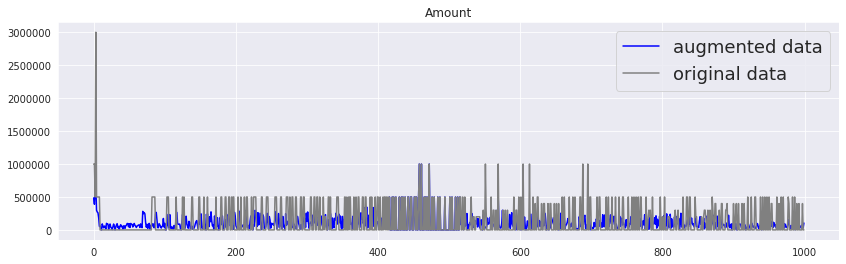

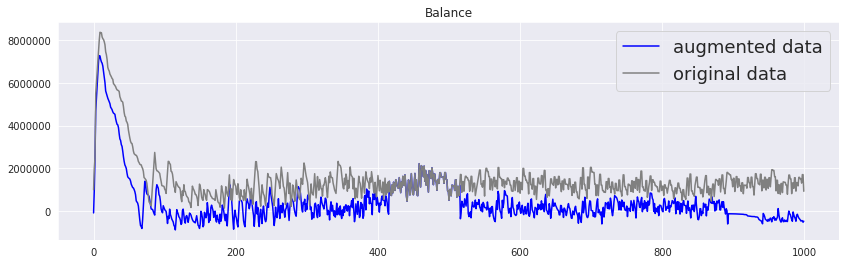

In [24]:

plt.figure(figsize=(14,4))
plt.plot(x_times[:1000],transfer_abnormal['x1'][:1000],color='blue',label = 'augmented data')
plt.plot(x_times[:1000],full_transfer["x1"][:1000],color='grey',label='original data')

plt.title("Amount")
plt.legend(fontsize=18)
plt.savefig(PATH+'/full_transfer_amount.png')

plt.figure(figsize=(14,4))
plt.plot(x_times[:1000],transfer_abnormal['x2'][:1000],color='blue',label = 'augmented data')
plt.plot(x_times[:1000],full_transfer["x2"][:1000],color='grey',label='original data')

plt.title("Balance")
plt.legend(fontsize=18)
plt.savefig(PATH+'/full_transfer_balance.png')

In [8]:
transfer_abnormal_cut = transfer_abnormal_
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(full_transfer.x1, full_transfer.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_y_.y == -1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_y_.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_y_.y == 1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_y_.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.xlim(full_transfer["x1"].min()-1.2e8,2e7)
plt.legend()
plt.savefig(PATH+'/Bank_Transaction_True2.png')


In [ ]:
# LOF
transfer_abnormal_cut=transfer_abnormal_
from sklearn.neighbors import LocalOutlierFactor
X_inliers = full_transfer.to_numpy()
X_outliers = transfer_abnormal_cut.to_numpy()
acc =0
clf = LocalOutlierFactor(n_neighbors=200, contamination=0.4)
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1
y_pred = clf.fit_predict(X)
y_pred_outliers = y_pred[len(full_transfer):]
# atm_abnormal["y"] = y_pred[:500]
transfer_abnormal_cut = transfer_abnormal_cut.assign(y = y_pred_outliers)

p1 = plt.scatter(full_transfer.x1, full_transfer.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_cut.y == -1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_cut.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_cut.y == 1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_cut.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")


plt.legend()
plt.xlim(full_transfer["x1"].min()-1.2e8,2e7)
for i in range(500):
    if(y_pred_outliers[i]==transfer_abnormal_y_.to_numpy()[i]):
        acc +=1
accuracy = (acc/500) *100
plt.savefig(PATH+'/Transfer_LOF_Pred_{:.4f}.png'.format(accuracy))
print("LOF : 이상치 데이터셋에서 정확도:", accuracy)

In [ ]:
# Isolation Forest
transfer_abnormal_cut=transfer_abnormal_
acc = 0
clf = IsolationForest(max_samples=500, contamination = 0.5, random_state=112)
clf.fit(full_transfer)
y_pred_train = clf.predict(full_transfer)

y_pred_outliers = clf.predict(transfer_abnormal_cut)
transfer_abnormal_cut = transfer_abnormal_cut.assign(y = y_pred_outliers)
p1 = plt.scatter(full_transfer.x1, full_transfer.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_cut.y == -1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_cut.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_cut.y == 1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_cut.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.xlim(full_transfer["x1"].min()-1.2e8,2e7)
plt.legend()
for i in range(500):
    if(y_pred_outliers[i]==transfer_abnormal_y_.to_numpy()[i]):
        acc +=1
accuracy = (acc/500) *100
plt.savefig(PATH+'/Transfer_IsolationForest_Pred_{:.4f}.png'.format(accuracy))
print("IsolationForest_이상치 데이터셋에서 정확도:", accuracy)

In [62]:
#For Anomaly Transformer
transfer_abnormal_y_np = transfer_abnormal_y_forat.to_numpy()
np.save("/home/bigdyl/Anomaly-Transformer/Transfer_test_label.npy",transfer_abnormal_y_np)
transfer_abnormal_y_ = transfer_abnormal_y
transfer_abnormal_ = transfer_abnormal

anomaly_transformer_result = np.load("/home/bigdyl/Anomaly-Transformer/anomaly_transormer_Transfer_result.npy")
transfer_abnormal_y_result =pd.DataFrame()
transfer_abnormal_y_result['y'] = anomaly_transformer_result


In [63]:
transfer_abnormal_cut = transfer_abnormal
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(full_transfer.x1, full_transfer.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_y_result.y == 0, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_y_result.y == 0, ['x2']], 
                 c='red', s=20*5, edgecolor='k', label="augmented outliers")
p3 = plt.scatter(transfer_abnormal_cut.loc[transfer_abnormal_y_result.y == 1, ['x1']], 
                 transfer_abnormal_cut.loc[transfer_abnormal_y_result.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="augmented regular obs")

plt.xlim(full_transfer["x1"].min()-1.2e8,2e7)
plt.legend()
plt.savefig(PATH+'/Anomaly_Transformer_Transfer_0.9692.png')
